In [80]:
import numpy as np
import matplotlib.pyplot as plt


# ReLU layer class
class ReLU:
    '''
    A class representing the Rectified Linear Unit (reLu) activation function.
    '''
    def __init__(self):
        self.input = None # placeholder for storing the input to the layer

    def forward_pass(self, input_data):
        self.input = input_data # store the input to use it in the backward pass
        return np.maximum(0, input_data) # apply the relu function: if x is negative, max(0, x) will be 0; otherwise, will be x

    def backward_pass(self, output_gradient):
        '''
        Compute the backward pass through the reLu activation function.

        The method calculates the gradient of the reLu function with respect 
        to its input 'x', given the gradient of the loss function with respect 
        to the output of the relu layer ('gradient_values').

        Parameters:
        - gradient_values (numpy.ndarray): The gradient of the loss function with respect 
                                           to the output of the relu layer.

        Returns:
        - numpy.ndarray: The gradient of the loss function with respect to the 
                         input of the relu layer.
        '''
        # apply the derivative of the relu function: if the input is negative, the derivative is 0; otherwise, the derivative is 1
        return output_gradient * (self.input > 0)
        #return output_gradient * np.where(self.input > 0, 1.0, 0.0) 

In [81]:
# Sigmoid layer class
class Sigmoid:
    '''
    A class representing the Sigmoid activation function.
    '''
    def __init__(self):
        self.output = None # placeholder for storing the output of the forward pass

    def forward_pass(self, input_data):
        self.output = 1 / (1 + np.exp(-input_data)) # apply the sigmoid function: f(x) = 1 / (1 + exp(-x))
        return self.output

    def backward_pass(self, output_gradient):
        '''
        Computes the backward pass of the Sigmoid activation function.

        Given the gradient of the loss function with respect to the output of the
        Sigmoid layer ('output_gradient'), this method calculates the gradient with respect
        to the Sigmoid input.

        Parameters:
        - output_gradient (numpy.ndarray): The gradient of the loss function with respect
                                           to the output of the Sigmoid layer.

        Returns:
        - numpy.ndarray: The gradient of the loss function with respect to the
                         input of the Sigmoid layer.
        '''
        return output_gradient * (self.output * (1 - self.output))

In [82]:
# Softmax layer class
class Softmax:
    '''
    A class representing the Softmax activation function.
    '''

    def forward_pass(self, input_data):
        '''
        Computes the forward pass of the Softmax activation function.

        Parameters:
        - input_data (numpy.ndarray): A numpy array containing the input data to which the Softmax
                             function should be applied.

        Returns:
        - numpy.ndarray: The result of applying the Softmax function to 'input_data', with the
                         same shape as 'input_data'.
        ''' 
        exp_values = np.exp(input_data - np.max(input_data, axis=1, keepdims=True)) # Shift the input data to avoid numerical instability in exponential calculations
        output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return output

    def backward_pass(self, dvalues):
        # The gradient of loss with respect to the input logits 
        # directly passed through in case of softmax + categorical cross-entropy
        return dvalues

In [83]:
class Dropout:    
    def __init__(self, probability):
        self.probability = probability
        
    def forward_pass(self, input_data):
        self.mask = np.random.binomial(1, 1-self.probability, size=input_data.shape) / (1-self.probability)
        return input_data * self.mask
    
    def backward_pass(self, output_gradient):
        return output_gradient * self.mask

In [84]:
# Dense layer class
class Layer:
    def __init__(self, input_size, output_size, l1=0.0, l2=0.0):
        self.weights = 0.01 * np.random.normal(0, 1/np.sqrt(input_size), (input_size, output_size)) # Normal distribution initialisation
        self.biases = np.full((1, output_size), 0.001) # Initialise biases with a small positive value
        self.velocity_weights = np.zeros_like(self.weights) # Initialise (weights) velocity terms for momentum optimization
        self.velocity_biases = np.zeros_like(self.biases) # Initialise (biases) velocity terms for momentum optimization
        self.l1 = l1 # L1 regularization coefficient (default 0.0).
        self.l2 = l2 # L2 regularization coefficient (default 0.0).
        self.input = None

    def forward_pass(self, input_data):
        self.input = input_data
        return np.dot(input_data, self.weights) + self.biases

    def backward_pass(self, output_gradient, learning_rate, optimizer='GD', momentum=0.9):
        '''
        Computes the backward pass of the Dense layer.

        Parameters:
        - output_gradient: The gradient of the loss function with respect to the output of the layer.

        - learning_rate: A hyperparameter that controls how much the weights and biases are updated during training.

        - optimizer: Specifies the optimization technique to use. Can be 'GD' for standard Gradient Descent or 'Momentum' for Gradient Descent with Momentum.

        - momentum: A hyperparameter representing the momentum coefficient, typically between 0 (no momentum) and 1.

        Returns:
        - numpy.ndarray: the gradient of the loss with respect to the layer's inputs (which will be passed back to the previous layer in the network).
        '''
        # Regularization terms
        l1_reg = self.l1 * np.sign(self.weights)
        l2_reg = self.l2 * self.weights

        weights_gradient = np.dot(self.input.T, output_gradient) + l1_reg + l2_reg
        input_gradient = np.dot(output_gradient, self.weights.T)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        if optimizer == 'GD':
            # Update weights and biases
            self.weights += learning_rate * weights_gradient
            self.biases += learning_rate * biases_gradient
        elif optimizer == 'Momentum':
            # Momentum update for weights and biases
            self.velocity_weights = momentum * self.velocity_weights + learning_rate * weights_gradient
            self.velocity_biases = momentum * self.velocity_biases + learning_rate * biases_gradient

            # Update weights and biases using velocity
            self.weights += self.velocity_weights
            self.biases += self.velocity_biases

        return input_gradient


In [85]:
# Neural Network wrapper class
class NeuralNetwork:
    def __init__(self):
        self.layers = [] # placeholder for storing the layers of the network so we can propagate the infomation in a sequential order
        self.loss_history = [] # placeholder to store the (train) loss for printing/plotting
        self.val_loss_history = [] #placeholder to store the loss function calculated on the validation set for printing/plotting
        self.accuracy_history = [] #placeholder to store the (train) accuracy for printing/plotting
        self.val_accuracy_history = [] #placeholder to store the accuracy calculated on the validation set for printing/plotting

    def add_layer(self, layer):
        '''
        Add the layer to the network
        '''
        self.layers.append(layer)

    def forward_pass(self, input_data):
        '''
        Performs a forward pass through the network. 
        It sequentially passes the input data through each layer, transforming it according to each layer's operation.
        '''
        for layer in self.layers:
            input_data = layer.forward_pass(input_data)
        return input_data
    
    def prediction(self, input_data):
        '''
        Performs a forward pass through the network ignoring the dropout.
        '''
        for layer in self.layers:
            if not isinstance(layer, Dropout):
                input_data = layer.forward_pass(input_data)
        return input_data
    
    def compute_accuracy(self, predictions, labels):
        '''
        Computes the accuracy of predictions by comparing them with the true labels. 
        Accuracy is computed as the proportion of correct predictions to the total number of predictions.
        '''
        return np.mean(predictions == labels)

    def backward_pass(self, output_gradient, learning_rate, optimizer='GD', momentum=0.9):
        '''
        Performs the backward pass (backpropagation) for training. 
        It propagates the gradient of the loss function backward through the network, updating weights in the process if the layer is a dense one.
        '''
        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                output_gradient = layer.backward_pass(output_gradient, learning_rate, optimizer, momentum)
            else:
                output_gradient = layer.backward_pass(output_gradient)
    
    def compute_categorical_cross_entropy_loss(self, y_pred, y_true):
        '''
        Computes the categorical cross entropy loss
        '''
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) # Clip predictions to prevent log(0)

        # Calculate the negative log of the probabilities of the correct class
        # Multiply with the one-hot encoded true labels and sum across classes
        loss = np.sum(y_true * -np.log(y_pred_clipped), axis=1)

        # Average loss over all samples
        return np.mean(loss)

    def compute_categorical_cross_entropy_gradient(self, y_pred, y_true):
        '''
        Calculates the gradient of the categorical cross entropy loss with respect to the network's output, assuming that the output layer is the softmax activation function.

        Parameters:
        - y_pred: Output of the softmax activation function.

        - y_true: One-hot encoded label array.
        '''
        # Assuming y_true is one-hot encoded and y_pred is the output of softmax
        y_pred_gradient = (y_pred - y_true) / len(y_pred)
        return y_pred_gradient

    def train(self, X_train, y_train, epochs=100, learning_rate=0.001, optimizer='GD', momentum=0.9, batch_size=32, validation_split = 0.2, verbose = 1):
        '''
        Conducts the training process over a specified number of epochs.

        Parameters:
        - X_train: The input features of the training data.

        - y_train: The target output (labels) of the training data.

        - epochs: The number of times the entire training dataset is passed forward and backward through the neural network.

        - learning_rate: The step size at each iteration while moving toward a minimum of the loss function.

        - optimizer: Specifies the optimization technique to use. Can be 'GD' for standard Gradient Descent or 'Momentum' for Gradient Descent with Momentum.

        - momentum: A hyperparameter representing the momentum coefficient, typically between 0 (no momentum) and 1.

        - batch_size: The number of training examples used in one iteration.

        - validation_split: Fraction of the training data to be used as validation data.

        - verbose: The mode of verbosity (0 = silent, 1 = update every 10 epochs, 2 = update every epoch).

        '''
        val_sample_size = int(len(X_train) * validation_split) # calculate validation sample size based on validation split parameter

        # Shuffles the indices of the training data to ensure random distribution
        indices = np.arange(len(X_train))
        np.random.shuffle(indices) 
        X_train, y_train = X_train[indices], y_train[indices]

        X_train, y_train = X_train[val_sample_size:], y_train[val_sample_size:] # splits the data into new training set.
        X_val, y_val = X_train[:val_sample_size], y_train[:val_sample_size] # splits the data into new validation set.

        n_samples = len(X_train)

        for epoch in range(epochs):
            # Shuffles the indices of the training data at the beginning of each epoch to improve generalisation
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            # Processing of the training data in batches
            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_x = X_train[start_idx:end_idx]
                batch_y = y_train[start_idx:end_idx]

                output = self.forward_pass(batch_x) # forward pass to get the output predictions
                loss_gradient = self.compute_categorical_cross_entropy_gradient(batch_y, output)
                self.backward_pass(loss_gradient, learning_rate, optimizer, momentum) # backward pass to update the network's weights

            # Calculate training loss for the epoch
            output = self.forward_pass(X_train)
            train_loss = self.compute_categorical_cross_entropy_loss(output, y_train)
            self.loss_history.append(train_loss)

            # Calculate training accuracy
            train_predictions = self.predict(X_train)
            train_accuracy = self.compute_accuracy(train_predictions, np.argmax(y_train, axis=1))
            self.accuracy_history.append(train_accuracy)

            # Calculate validation loss for the epoch
            val_output = self.prediction(X_val)  # ensure dropout is not applied
            val_loss = self.compute_categorical_cross_entropy_loss(val_output, y_val)
            self.val_loss_history.append(val_loss)

            # Calculate validation accuracy
            val_predictions = self.predict(X_val)
            val_accuracy = self.compute_accuracy(val_predictions, np.argmax(y_val, axis=1))
            self.val_accuracy_history.append(val_accuracy)

            # Printing
            if verbose == 1:
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} --- Train Loss: {train_loss} --- Val Loss: {val_loss} --- Train Acc: {train_accuracy:.2f} --- Val Acc: {val_accuracy:.2f}")
            elif verbose == 2:
                print(f"Epoch {epoch}/{epochs} --- Train Loss: {train_loss} --- Val Loss: {val_loss} --- Train Acc: {train_accuracy:.2f} --- Val Acc: {val_accuracy:.2f}")
            epoch += 1

    def predict(self, X_test):
        '''
        Uses the trained network to make predictions on new data (X_test).
        '''
        output = self.prediction(X_test) # use prediction method to avoid dropout

        predictions = np.argmax(output, axis=1) # convert probabilities to class predictions
        return predictions

    def plot_loss(self):
        '''
        Plots the loss history stored in self.loss_history over the epochs.
        '''
        plt.plot(self.loss_history, label = 'Train Loss')
        plt.plot(self.val_loss_history, label = 'Val Loss')
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        plt.plot(self.accuracy_history, label='Train Accuracy')
        plt.plot(self.val_accuracy_history, label='Val Accuracy')
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()


In [86]:
def standardize_data(X):
    # Calculate the mean and standard deviation for each feature
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    # Avoid division by zero in case of a constant feature
    stds[stds == 0] = 1

    # Standardize each feature
    X_standardized = (X - means) / stds
    return X_standardized

c:\Users\aless\miniconda3\envs\IntroductionToAI\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0/1000 --- Train Loss: 2.301149184562769 --- Val Loss: 2.300736748531308 --- Train Acc: 0.11 --- Val Acc: 0.11
Epoch 10/1000 --- Train Loss: 0.26111784806899657 --- Val Loss: 0.1405624934320048 --- Train Acc: 0.97 --- Val Acc: 0.97
Epoch 20/1000 --- Train Loss: 0.13999185954586968 --- Val Loss: 0.058701739610862155 --- Train Acc: 0.99 --- Val Acc: 0.99
Epoch 30/1000 --- Train Loss: 0.09706131062311331 --- Val Loss: 0.03645762801623091 --- Train Acc: 1.00 --- Val Acc: 0.99
Epoch 40/1000 --- Train Loss: 0.08681233868346758 --- Val Loss: 0.024422495935272907 --- Train Acc: 1.00 --- Val Acc: 1.00
Epoch 50/1000 --- Train Loss: 0.08007441669030321 --- Val Loss: 0.017889867157877198 --- Train Acc: 1.00 --- Val Acc: 1.00
Epoch 60/1000 --- Train Loss: 0.056523796581669034 --- Val Loss: 0.013773008041217718 --- Train Acc: 1.00 --- Val Acc: 1.00
Epoch 70/1000 --- Train Loss: 0.039384841323872995 --- Val Loss: 0.009640593151864328 --- Train Acc: 1.00 --- Val Acc: 1.00
Epoch 80/1000 --- Train

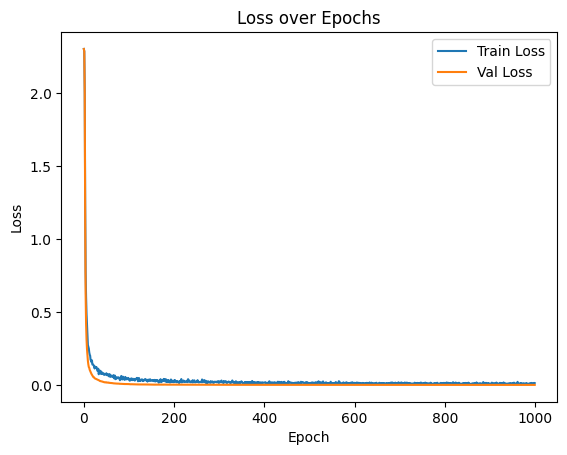

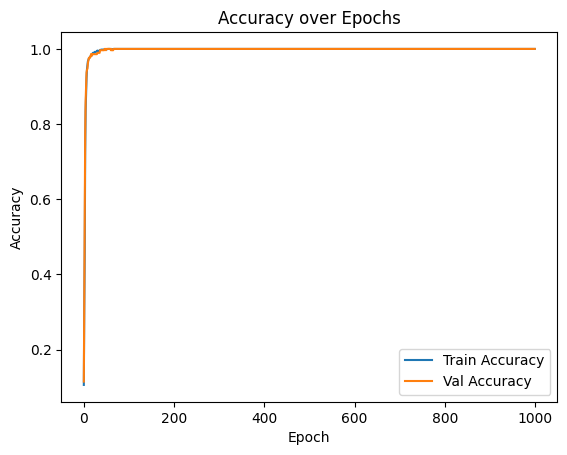


Accuracy: 0.9777777777777777


In [114]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

# Standardize the features
X = standardize_data(X)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse=False)
y = one_hot_encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
network = NeuralNetwork()
network.add_layer(Layer(64, 32))  # 64 inputs (8x8 images)
network.add_layer(ReLU())
network.add_layer(Dropout(0.25))
#network.add_layer(Layer(128, 64, l2=0.01)) 
#network.add_layer(ReLU())
#network.add_layer(Layer(64, 32, l2=0.01)) 
#network.add_layer(ReLU())
network.add_layer(Layer(32, 10))  # 10 classes
network.add_layer(Softmax())

# Train the network
network.train(X_train, y_train, epochs=1000, learning_rate=0.1, optimizer='GD', momentum=0.5, batch_size=32)

network.plot_loss()
network.plot_accuracy()

# Evaluate the performance of the model
y_pred = network.predict(X_test)
y_test = np.argmax(y_test, axis=1) # transoform back the One-Hot encoded array of the labels

accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy}")

Epoch 0/10000 --- Train Loss: 0.692580580099927 --- Val Loss: 0.6925675160760685 --- Train Acc: 0.62 --- Val Acc: 0.64


c:\Users\aless\miniconda3\envs\IntroductionToAI\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 10/10000 --- Train Loss: 0.6917478463225849 --- Val Loss: 0.6916211815475471 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 20/10000 --- Train Loss: 0.6909314623554517 --- Val Loss: 0.6906918476296456 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 30/10000 --- Train Loss: 0.6901410915624723 --- Val Loss: 0.6897906221033159 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 40/10000 --- Train Loss: 0.6893745344435445 --- Val Loss: 0.6889151167051457 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 50/10000 --- Train Loss: 0.6886290103390257 --- Val Loss: 0.6880622703332071 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 60/10000 --- Train Loss: 0.6878967168480163 --- Val Loss: 0.687223201092859 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 70/10000 --- Train Loss: 0.6871935328302484 --- Val Loss: 0.6864162533883401 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 80/10000 --- Train Loss: 0.6865073820049669 --- Val Loss: 0.6856276901563867 --- Train Acc: 0.62 --- Val Acc: 0.64
Epoch 90/10000 --- Train Loss: 0.

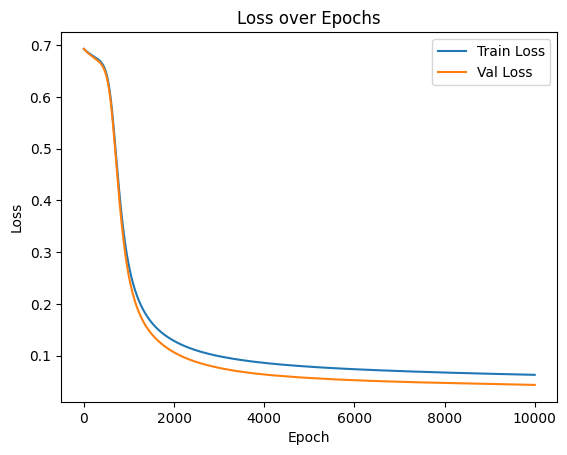


Accuracy: 0.9912280701754386


In [88]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

X = dataset.data
y = dataset.target

# Standardize the features
X = standardize_data(X)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse=False)
y = one_hot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
network = NeuralNetwork()
network.add_layer(Layer(X_train.shape[1], 128))
network.add_layer(ReLU())
network.add_layer(Layer(128, 2))
network.add_layer(Sigmoid())

# Train the network
network.train(X_train, y_train, epochs=10000, learning_rate=0.001, batch_size=16)

network.plot_loss()

# Evaluate the performance of the model
y_pred = network.predict(X_test)
y_test = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy}")

# Next Step

* optimization of hyperparameters (random search and grid search function?)